<a href="https://colab.research.google.com/github/Nmg1994/Crop_mapping/blob/main/Crop_mapping_DL_based_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intalling necessary packages

In [2]:
!pip install rasterio
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 104.6 MB/s eta 0:00:00


# Importing necessary libraries/modules

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.preprocessing import OneHotEncoder
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Concatenate, Layer, Conv1D, MaxPooling1D, Lambda
from keras.callbacks import EarlyStopping
import pickle
from scipy.stats import ks_2samp
from itertools import combinations
import pandas as pd
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import rasterio
from sklearn.metrics import confusion_matrix

# Mounting Google Drive

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Loading training, validation, and test datasets as well as the class weight

In [4]:
# loading samples along with their corresponding labels # this is done to save some RAM due to the huge size of data
train_indices = np.load('/content/drive/My Drive/DL_samples/train_indices.npy')
val_indices = np.load('/content/drive/My Drive/DL_samples/val_indices.npy')
test_indices = np.load('/content/drive/My Drive/DL_samples/test_indices.npy')

train_labels = np.load('/content/drive/My Drive/DL_samples/train_labels.npy')
val_labels = np.load('/content/drive/My Drive/DL_samples/val_labels.npy')
test_labels = np.load('/content/drive/My Drive/DL_samples/test_labels.npy')


train_samples = np.load('/content/drive/My Drive/DL_samples/train_samples.npy')
val_samples = np.load('/content/drive/My Drive/DL_samples/val_samples.npy')
test_samples = np.load('/content/drive/My Drive/DL_samples/test_samples.npy')

# Loading the class weight dictionary from the Google Drive
with open('/content/drive/My Drive/DL_samples/class_weights_dict_indices.pkl', 'rb') as f:
  class_weights_dict = pickle.load(f)

# Assessing whether the datasets conform the IID assumption

In [ ]:
# Investigating the conformity of the datasets to the IID assumption
# Calculating class distributions for each dataset
train_class_distribution = np.bincount(train_labels) / len(train_labels)
val_class_distribution = np.bincount(val_labels) / len(val_labels)
test_class_distribution = np.bincount(test_labels) / len(test_labels)

# Printing class distributions for each dataset
print("Training set class distribution:", train_class_distribution)
print("Validation set class distribution:", val_class_distribution)
print("Testing set class distribution:", test_class_distribution)

# Defining a function to perform Kolmogorov-Smirnov test and Chi-squared test
def perform_tests(labels1, labels2, dataset_name1, dataset_name2):
    # Performing Kolmogorov-Smirnov test
    ks_statistic, p_value_ks = ks_2samp(labels1, labels2)
    print(f"Kolmogorov-Smirnov test statistic for {dataset_name1} vs. {dataset_name2} datasets:", ks_statistic)
    print(f"p-value for Kolmogorov-Smirnov test between {dataset_name1} vs. {dataset_name2} datasets:", p_value_ks)

# Performing pairwise comparisons between all three datasets
datasets = [("Training", train_labels), ("Validation", val_labels), ("Test", test_labels)]
for dataset1, dataset2 in combinations(datasets, 2):
    dataset_name1, labels1 = dataset1
    dataset_name2, labels2 = dataset2
    perform_tests(labels1, labels2, dataset_name1, dataset_name2)

Training set class distribution: [0.10927318 0.07196929 0.11284642 0.108223   0.07470647 0.0800896
 0.09464043 0.00314869 0.02418869 0.03129792 0.10622132 0.07761031
 0.10578467]
Validation set class distribution: [0.10927388 0.07196943 0.11284624 0.10822368 0.07470666 0.08008893
 0.09464091 0.00314781 0.02418812 0.03129652 0.10622104 0.07761147
 0.10578532]
Testing set class distribution: [0.10927057 0.07196821 0.11284552 0.10822322 0.07470807 0.08009004
 0.09463841 0.00315322 0.02418956 0.03130036 0.10622069 0.07760713
 0.10578499]
Kolmogorov-Smirnov test statistic for Training vs. Validation datasets: 1.8009067400681644e-06
p-value for Kolmogorov-Smirnov test between Training vs. Validation datasets: 1.0
Kolmogorov-Smirnov test statistic for Training vs. Test datasets: 4.598941280575808e-06
p-value for Kolmogorov-Smirnov test between Training vs. Test datasets: 1.0
Kolmogorov-Smirnov test statistic for Validation vs. Test datasets: 5.7150727899024645e-06
p-value for Kolmogorov-Smirn

# Preprocessing the datasets and their corresponding labels

In [6]:
# One-hot encoding labels
labels = np.concatenate([train_labels, val_labels, test_labels])
print('labels shape:', labels.shape)
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_encoded = encoder.fit_transform(labels.reshape(-1, 1))
one_hot_array = np.array(one_hot_encoded)
print('one_hot_array shape:', one_hot_array.shape)

train_labels_encoded = one_hot_array[:len(train_labels),:]
val_labels_encoded = one_hot_array[len(train_labels): (len(train_labels) + len(val_labels)),:]
test_labels_encoded = one_hot_array[(len(train_labels) + len(val_labels)):,:]

print('train_labels_encoded shape:', train_labels_encoded.shape)
print('val_labels_encoded shape:', val_labels_encoded.shape)
print('test_labels_encoded shape:', test_labels_encoded.shape)

labels shape: (1790171,)
one_hot_array shape: (1790171, 13)
train_labels_encoded shape: (1074097, 13)
val_labels_encoded shape: (358027, 13)
test_labels_encoded shape: (358047, 13)


In [ ]:
# Transposing the spectral and temporal domains to apply the convolutions on the spectral domain
# This cell must be run only in applying convolutions over the spectral domain (i.e., using 1DSpecCNNs model)
train_samples= np.transpose(train_samples, (0,2,1))
val_samples= np.transpose(val_samples, (0,2,1))
test_samples= np.transpose(test_samples, (0,2,1))

# Plotting heatmaps of the designed architecture for the initial-architecture configuration of DL models

Having run the codes "Searching_the_optimized_initial_1DTempCNNs_architecture.py", "Searching_the_optimized_initial_1DSpecCNNs_architecture.py", and "Searching_the_optimized_initial_LSTM_architecture.py", this part can be run

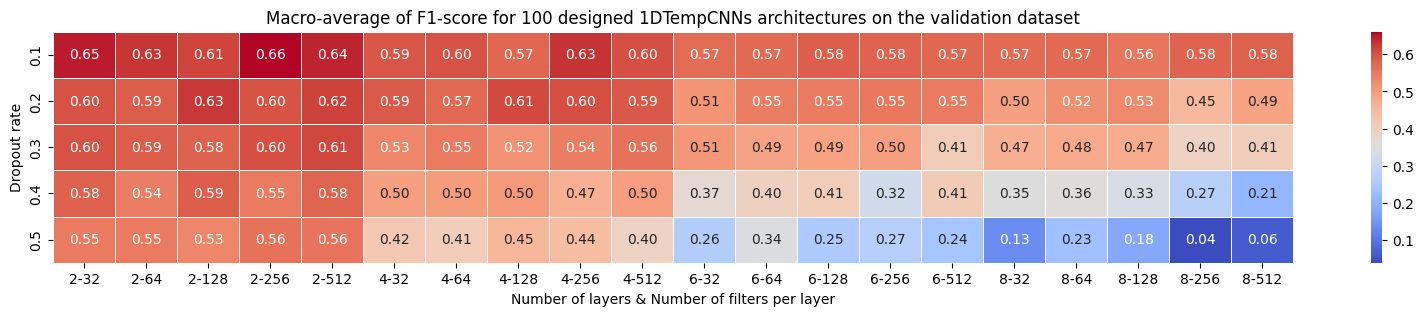

In [ ]:
# Architecture tuning of the 1DTempCNNs architecture and investigating the influence of the hyperparameters on the models' accuracy
CNN_architecture_results_temp = pd.read_excel('/content/drive/My Drive/Initial_architectures/CNN_architecture_temporal.xlsx')
# Pivoting the dataframe to create a matrix suitable for heatmap
heatmap_data = CNN_architecture_results_temp.pivot_table(index=['dropout_val'], columns=['num_layers', 'num_filters'], values='Validation_accuracy')

# Plotting the heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.7, fmt=".2f")
plt.title('Macro-average of F1-score for 100 designed 1DTempCNNs architectures on the validation dataset')
plt.xlabel('Number of layers & Number of filters per layer')
plt.ylabel('Dropout rate')
plt.show()

In [ ]:
# Performing ANOVA for each hyperparameter independently
for hyperparam in ['num_layers', 'num_filters', 'dropout_val']:
  model = ols(f'Validation_accuracy ~ C({hyperparam})', data=CNN_architecture_results_temp).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  print(f"ANOVA results for {hyperparam}:\n")
  print(anova_table)
  print("\n" + "="*50 + "\n")

ANOVA results for num_layers:

                 sum_sq    df          F        PR(>F)
C(num_layers)  0.586094   3.0  16.577202  9.326989e-09
Residual       1.131374  96.0        NaN           NaN


ANOVA results for num_filters:

                  sum_sq    df         F    PR(>F)
C(num_filters)  0.008104   4.0  0.112599  0.977819
Residual        1.709365  95.0       NaN       NaN


ANOVA results for dropout_val:

                  sum_sq    df          F        PR(>F)
C(dropout_val)  0.814524   4.0  21.424294  1.283078e-12
Residual        0.902945  95.0        NaN           NaN




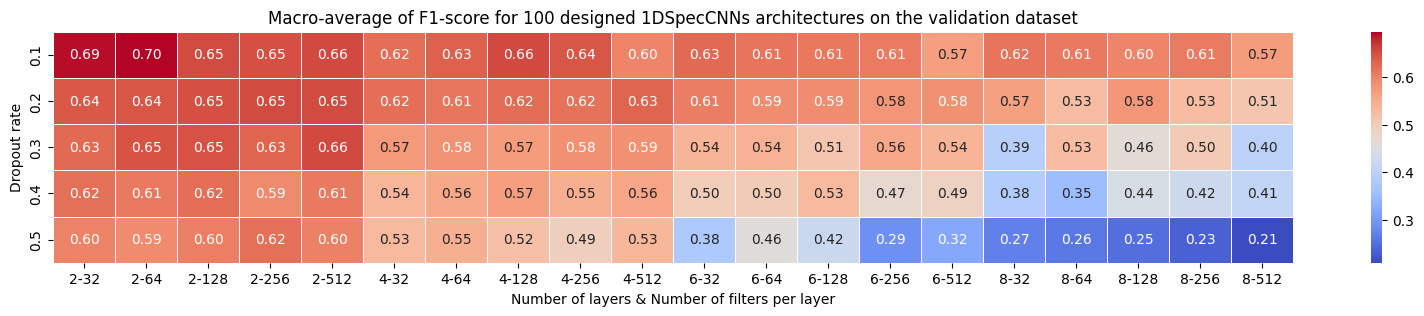

In [7]:
# Architecture tuning of the 1DTempCNNs architecture and investigating the influence of the hyperparameters on the models' accuracy
CNN_architecture_results_spec = pd.read_excel('/content/drive/My Drive/Initial_architectures/CNN_architecture_spectral.xlsx')
# Pivoting the dataframe to create a matrix suitable for heatmap
heatmap_data_spec = CNN_architecture_results_spec.pivot_table(index=['dropout_val'], columns=['num_layers', 'num_filters'], values='Validation_accuracy')

# Plotting the heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data_spec, annot=True, cmap='coolwarm', linewidths=0.7, fmt=".2f")
plt.title('Macro-average of F1-score for 100 designed 1DSpecCNNs architectures on the validation dataset')
plt.xlabel('Number of layers & Number of filters per layer')
plt.ylabel('Dropout rate')
plt.show()

In [8]:
# Performing ANOVA for each hyperparameter independently
for hyperparam in ['num_layers', 'num_filters', 'dropout_val']:
  model = ols(f'Validation_accuracy ~ C({hyperparam})', data=CNN_architecture_results_spec).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  print(f"ANOVA results for {hyperparam}:\n")
  print(anova_table)
  print("\n" + "="*50 + "\n")

ANOVA results for num_layers:

                 sum_sq    df          F        PR(>F)
C(num_layers)  0.481726   3.0  23.031661  2.577077e-11
Residual       0.669306  96.0        NaN           NaN


ANOVA results for num_filters:

                  sum_sq    df         F    PR(>F)
C(num_filters)  0.006707   4.0  0.139193  0.967302
Residual        1.144326  95.0       NaN       NaN


ANOVA results for dropout_val:

                  sum_sq    df          F        PR(>F)
C(dropout_val)  0.450318   4.0  15.263084  1.130893e-09
Residual        0.700714  95.0        NaN           NaN




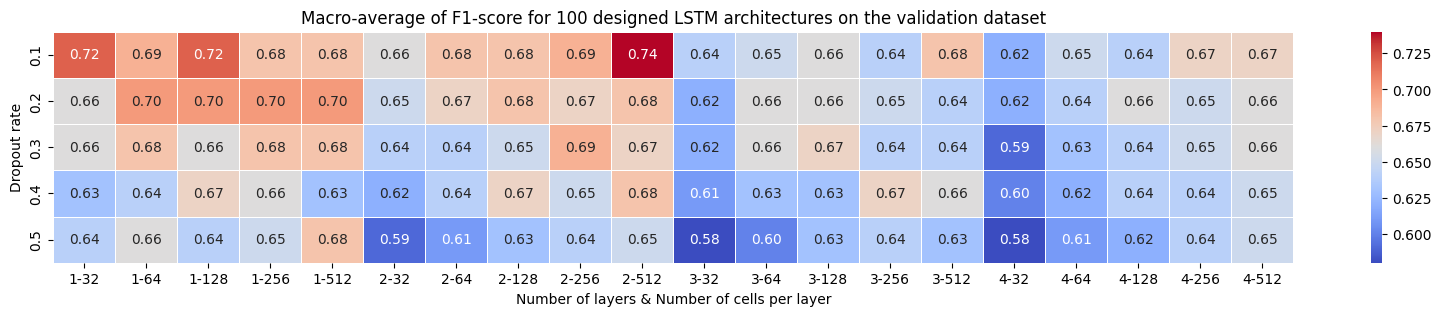

In [9]:
# Architecture tuning of the 1DTempCNNs architecture and investigating the influence of the hyperparameters on the models' accuracy
LSTM_architecture_results = pd.read_excel('/content/drive/My Drive/Initial_architectures/LSTM_architecture.xlsx')

# Pivoting the dataframe to create a matrix suitable for heatmap
heatmap_data = LSTM_architecture_results.pivot_table(index=['dropout_rate'], columns=['num_layers', 'num_cells'], values='Validation_accuracy')

# plotting the heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.7, fmt=".2f")
plt.title('Macro-average of F1-score for 100 designed LSTM architectures on the validation dataset')
plt.xlabel('Number of layers & Number of cells per layer')
plt.ylabel('Dropout rate')
plt.show()

In [10]:
# Performing ANOVA for each hyperparameter independently
for hyperparam in ['num_layers', 'num_cells', 'dropout_rate']:
  model = ols(f'Validation_accuracy ~ C({hyperparam})', data=LSTM_architecture_results).fit()
  anova_table = sm.stats.anova_lm(model, typ=2)
  print(f"ANOVA results for {hyperparam}:\n")
  print(anova_table)
  print("\n" + "="*50 + "\n")

ANOVA results for num_layers:

                 sum_sq    df          F    PR(>F)
C(num_layers)  0.021323   3.0  10.494894  0.000005
Residual       0.065016  96.0        NaN       NaN


ANOVA results for num_cells:

                sum_sq    df         F    PR(>F)
C(num_cells)  0.018414   4.0  6.438462  0.000125
Residual      0.067925  95.0       NaN       NaN


ANOVA results for dropout_rate:

                   sum_sq    df         F    PR(>F)
C(dropout_rate)  0.024514   4.0  9.417024  0.000002
Residual         0.061825  95.0       NaN       NaN




# Modifying the initial architecures of each DL model and exploring the one with optimal performance and using them for the prediction and accuracy assessment on the testing dataset

Defininf the LSTM model with the optimal architecture

In [9]:
# LSTM model
def LSTM_classification(Features_training_LSTM, Features_val_LSTM, Features_testing_LSTM, landcover_training_LSTM, landcover_val_LSTM, landcover_testing_LSTM, time_steps, num_features, num_classes, Prediction_only = False):

  # Defining early stopping callback
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

  # Designing the architecture for the LSTM model
  LSTM_model = Sequential()
  LSTM_model.add(LSTM(units = 512, return_sequences= True, input_shape=(num_features, time_steps)))
  LSTM_model.add(Dropout(0.1))
  LSTM_model.add(LSTM(units = 128, return_sequences= True))
  LSTM_model.add(Dropout(0.1))
  LSTM_model.add(Flatten())
  LSTM_model.add(Dense(units = 512, activation = 'relu'))
  LSTM_model.add(Dense(num_classes, activation='softmax'))

  learning_rate = 0.001
  adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  # Compiling the LSTM model
  LSTM_model.compile(optimizer= adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  # Training the LSTM model
  LSTM_history = LSTM_model.fit(Features_training_LSTM, landcover_training_LSTM, epochs=100, batch_size=32, validation_data=(Features_val_LSTM, landcover_val_LSTM),  callbacks=[early_stopping])

  # Access the stopped epoch
  final_epoch = early_stopping.stopped_epoch
  print("Training stopped at epoch:", final_epoch + 1)

  sns.set(font_scale=1)
  sns.set_style("darkgrid")
  plt.figure(figsize=(15, 4))

  print('The average accuracy over all epochs: ', sum(LSTM_history.history['val_accuracy']) / len(LSTM_history.history['val_accuracy']))

  # Plotting training accuracy
  sns.lineplot(x=range(1, final_epoch + 2), y= LSTM_history.history['accuracy'], label='Training accuracy')

  # Plotting validation accuracy
  sns.lineplot(x=range(1, final_epoch + 2), y= LSTM_history.history['val_accuracy'], label='Validation accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation accuracy of LSTM model Over Epochs')
  plt.legend()
  plt.show()

  LSTM_model.summary()


  #Testing Accuracy
  landcover_testing_predicted = LSTM_model.predict(Features_testing_LSTM)
  # Finding the index of the highest probability for each sample
  max_prob_indices = np.argmax(landcover_testing_predicted, axis=1)

  # Creating a binary array with the same shape as landcover_testing_predicted
  binary_array = np.zeros_like(landcover_testing_predicted)

  # Setting the value of 1 at the index of the highest probability for each sample
  binary_array[np.arange(len(landcover_testing_predicted)), max_prob_indices] = 1


  if Prediction_only == False:
    print("Recall score for test dataset: ", sklearn.metrics.recall_score(landcover_testing_LSTM, binary_array, average = 'macro'))
    print("Precision score for test dataset: ", sklearn.metrics.precision_score(landcover_testing_LSTM, binary_array, average = 'macro'))
    print("F1 score for test dataset: ", sklearn.metrics.f1_score(landcover_testing_LSTM, binary_array, average = 'macro'))
    print("ROC-AUC score for test dataset: ", sklearn.metrics.roc_auc_score(landcover_testing_LSTM, binary_array, average = 'macro', multi_class = 'ovr'))

    print(sklearn.metrics.classification_report(landcover_testing_LSTM, binary_array))

    # Creating an empty dictionary to store ROC AUC scores for each class
    roc_auc_scores = {}

    # Iterating over each class
    for class_index in range(num_classes):
        # Extracting the binary predictions for the current class
        binary_predictions_class = binary_array[:, class_index]
        true_labels_class = landcover_testing_LSTM[:, class_index]

        # Computing the ROC-AUC score for the current class
        roc_auc = sklearn.metrics.roc_auc_score(true_labels_class, binary_predictions_class)

        # Storing the ROC AUC score for the current class in the dictionary
        roc_auc_scores[f'Class {class_index}'] = roc_auc

    # Printing ROC-AUC scores for each class
    for class_name, roc_auc in roc_auc_scores.items():
        print(f'ROC AUC for {class_name}: {roc_auc}')

Applying LSTM model

Epoch 1/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 207s 6ms/step - accuracy: 0.6538 - loss: 0.9973 - val_accuracy: 0.7254 - val_loss: 0.7842
Epoch 2/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 206s 6ms/step - accuracy: 0.7273 - loss: 0.7782 - val_accuracy: 0.7407 - val_loss: 0.7399
Epoch 3/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 205s 6ms/step - accuracy: 0.7442 - loss: 0.7280 - val_accuracy: 0.7502 - val_loss: 0.7101
Epoch 4/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 206s 6ms/step - accuracy: 0.7560 - loss: 0.6919 - val_accuracy: 0.7577 - val_loss: 0.6911
Epoch 5/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 207s 6ms/step - accuracy: 0.7650 - loss: 0.6649 - val_accuracy: 0.7610 - val_loss: 0.6820
Epoch 6/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 208s 6ms/step - accuracy: 0.7723 - loss: 0.6415 - val_accuracy: 0.7657 - val_loss: 0.6709
Epoch 7/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 208s 6ms/step - accuracy: 0.7797 - loss: 0.6190 - val_accuracy: 0.7680 - val_loss: 0.6643
Epoch 8/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 208s 6ms/s

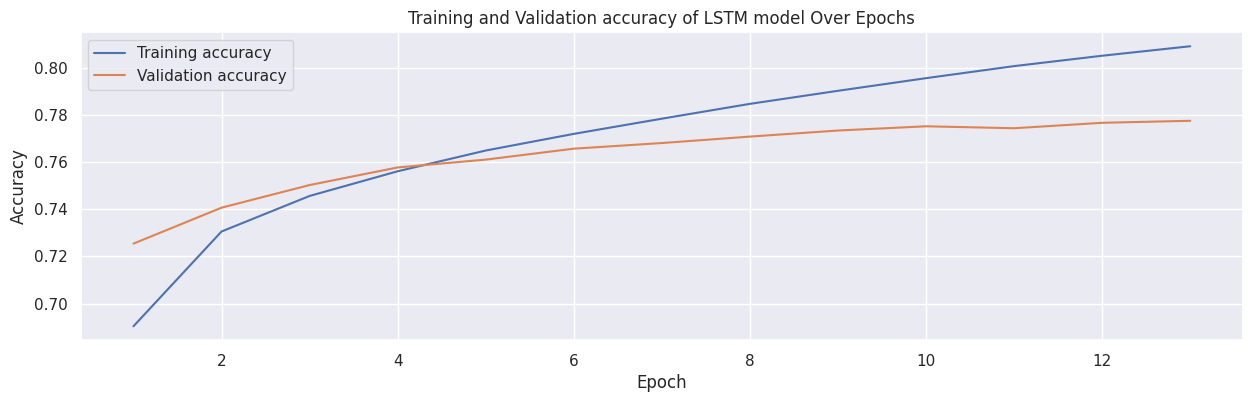

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 512)             │       1,095,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 128)             │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │           6,669 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,259,241 (23.88 MB)

 Trainable params: 2,086,413 (7.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,172,828 (15.92 MB)

11189/11189 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
Recall score for test dataset:  0.804983146126303
Precision score for test dataset:  0.7956068959595057
F1 score for test dataset:  0.7992948317426005
ROC-AUC score for test dataset:  0.8928996721660156
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     39124
           1       0.81      0.76      0.79     25768
           2       0.97      0.98      0.97     40404
           3       0.55      0.63      0.58     38749
           4       0.71      0.72      0.72     26749
           5       0.67      0.64      0.65     28676
           6       0.63      0.60      0.61     33885
           7       0.84      0.93      0.89      1129
           8       0.89      0.94      0.92      8661
           9       0.97      0.98      0.98     11207
          10       0.89      0.93      0.91     38032
          11       0.88      0.94      0.91     27787
          12       0.77      0.65      0.71     

In [ ]:
# Following the goal set the inputs of the LSTM model:
# If only four bands are being used, use the inputs train_samples, val_samples, test_samples; other wise use the inputs Standarizad_train_samples, Standarizad_val_samples, Standarizad_test_samples
# Also, do not forget to correspondingly change the time_steps and num_features parameters
LSTM_classification(Features_training_LSTM = train_samples, Features_val_LSTM = val_samples, Features_testing_LSTM = test_samples, landcover_training_LSTM = train_labels_encoded, landcover_val_LSTM = val_labels_encoded, landcover_testing_LSTM = test_labels_encoded, time_steps = train_samples.shape[2], num_features = train_samples.shape[1], num_classes = 13, Prediction_only = False)


Defininf the inception layer for the CNNs models

In [ ]:
# Designing an inception layer for the CNNs models
class InceptionLayer(Layer):
    def __init__(self, filters, **kwargs):
        super(InceptionLayer, self).__init__(**kwargs)
        self.filters = filters
        # Define layers here to avoid tf.function issues
        self.conv1_3 = Conv1D(filters[0], 3, padding='same', activation='relu')
        self.conv1_1 = Conv1D(filters[0], 1, padding='same', activation='relu')

        self.conv2_5 = Conv1D(filters[1], 5, padding='same', activation='relu')
        self.conv2_3 = Conv1D(filters[1], 3, padding='same', activation='relu')

        self.conv3_5 = Conv1D(filters[2], 5, padding='same', activation='relu')
        self.conv3_1 = Conv1D(filters[2], 1, padding='same', activation='relu')


    def call(self, inputs):
        # Branch 1: 3 Convolution followed by 1 Convolution
        branch1 = self.conv1_3(inputs)
        branch1 = self.conv1_1(branch1)

        # Branch 2: 5 Convolution followed by 3 Convolution
        branch2 = self.conv2_5(inputs)
        branch2 = self.conv2_3(branch2)

        # Branch 3: 5 Convolution followed by 1 Convolution
        branch3 = self.conv3_5(inputs)
        branch3 = self.conv3_1(branch3)

        # Concatenate the outputs of the branches
        output = Concatenate(axis=-1)([branch1, branch2, branch3])

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], sum(self.filters)


Defining the 1DTempCNNs model with the optimal architecture

In [ ]:
# 1DTempCNNs model
def TempCNNs(Features_training_CNN, Features_val_CNN, Features_testing_CNN, landcover_training_CNN, landcover_val_CNN, landcover_testing_CNN, time_steps, num_features, num_classes, Prediction_only = False):

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Designing the architecture for the 1DTempCNNs model
    CNN_model = Sequential()

    CNN_model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same', input_shape=(num_features, time_steps)))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(InceptionLayer(filters = (256, 512, 256)))
    CNN_model.add(Dropout(0.1))
    # Flatten layer
    CNN_model.add(Flatten())
    # Fully connected layers
    CNN_model.add(Dense(512, activation='relu'))
    # Output layer
    CNN_model.add(Dense(num_classes, activation='softmax'))

    # Compiling the 1DTempCNNs model
    CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the 1DTempCNNs model
    CNN_history = CNN_model.fit(Features_training_CNN, landcover_training_CNN, epochs=100, batch_size=32, validation_data=(Features_val_CNN, landcover_val_CNN),  callbacks=[early_stopping])

    # Accessing the stopped epoch
    final_epoch = early_stopping.stopped_epoch
    print("Training stopped at epoch:", final_epoch + 1)

    sns.set(font_scale=1)
    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 4))

    print('The average accuracy over all epochs: ', sum(CNN_history.history['val_accuracy']) / len(CNN_history.history['val_accuracy']))

    # Plotting training accuracy
    sns.lineplot(x=range(1, final_epoch + 2), y= CNN_history.history['accuracy'], label='Training accuracy')

    # Plotting validation accuracy
    sns.lineplot(x=range(1, final_epoch + 2), y= CNN_history.history['val_accuracy'], label='Validation accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation accuracy of 1DTempCNNs Over Epochs')
    plt.legend()
    plt.show()

    CNN_model.summary()

    #Testing Accuracy
    landcover_testing_predicted = CNN_model.predict(Features_testing_CNN)
    # Finding the index of the highest probability for each sample
    max_prob_indices = np.argmax(landcover_testing_predicted, axis=1)

    # Creating a binary array with the same shape as landcover_testing_predicted
    binary_array = np.zeros_like(landcover_testing_predicted)

    # Setting the value of 1 at the index of the highest probability for each sample
    binary_array[np.arange(len(landcover_testing_predicted)), max_prob_indices] = 1

    if Prediction_only == False:
      print("Recall score for test dataset: ", sklearn.metrics.recall_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("Precision score for test dataset: ", sklearn.metrics.precision_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("F1 score for test dataset: ", sklearn.metrics.f1_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("ROC-AUC score for test dataset: ", sklearn.metrics.roc_auc_score(landcover_testing_CNN, binary_array, average = 'macro', multi_class = 'ovr'))

      print(sklearn.metrics.classification_report(landcover_testing_CNN, binary_array))

      # Creating an empty dictionary to store ROC-AUC scores for each class
      roc_auc_scores = {}

      # Iterating over each class
      for class_index in range(num_classes):
          # Extracting the binary predictions for the current class
          binary_predictions_class = binary_array[:, class_index]
          true_labels_class = landcover_testing_CNN[:, class_index]

          # Computing ROC-AUC score for the current class
          roc_auc = sklearn.metrics.roc_auc_score(true_labels_class, binary_predictions_class)

          # Storing the ROC-AUC score for the current class in the dictionary
          roc_auc_scores[f'Class {class_index}'] = roc_auc

      # Printing ROC-AUC scores for each class
      for class_name, roc_auc in roc_auc_scores.items():
          print(f'ROC AUC for {class_name}: {roc_auc}')


Applying the 1DTempCNNs model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 109s 3ms/step - accuracy: 0.6562 - loss: 0.9961 - val_accuracy: 0.7059 - val_loss: 0.8500
Epoch 2/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.7006 - loss: 0.8676 - val_accuracy: 0.7104 - val_loss: 0.8383
Epoch 3/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.7049 - loss: 0.8535 - val_accuracy: 0.7154 - val_loss: 0.8199
Epoch 4/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.7078 - loss: 0.8476 - val_accuracy: 0.7152 - val_loss: 0.8256
Epoch 5/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.7097 - loss: 0.8440 - val_accuracy: 0.7182 - val_loss: 0.8183
Epoch 6/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - accuracy: 0.7091 - loss: 0.8438 - val_accuracy: 0.7188 - val_loss: 0.8159
Epoch 7/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - accuracy: 0.7097 - loss: 0.8457 - val_accuracy: 0.7121 - val_loss: 0.8410
Epoch 8/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step - a

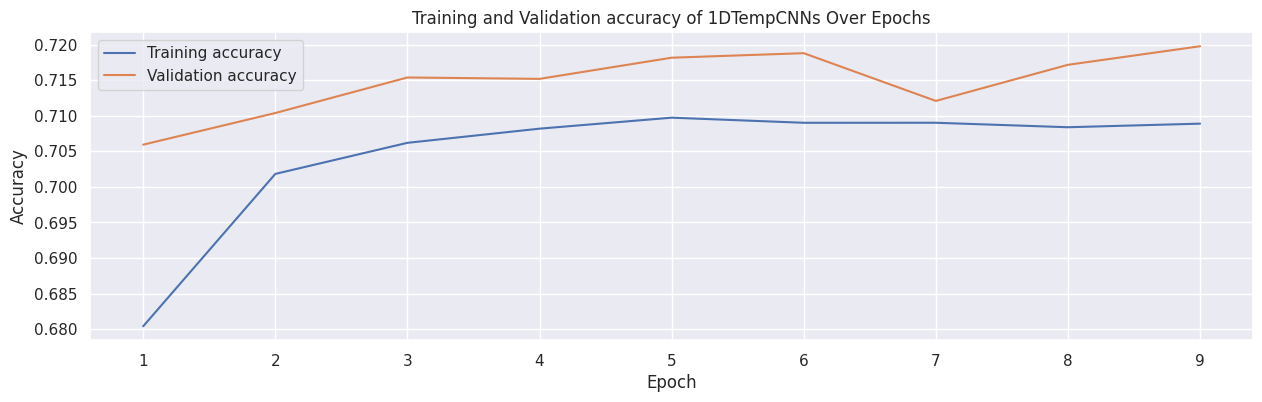

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)                    │ (None, 10, 256)             │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_layer_1 (InceptionLayer)   │ (None, 10, 1024)            │       2,099,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 13)                  │           6,669 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,099,241 (84.30 MB)

 Trainable params: 7,366,413 (28.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,732,828 (56.20 MB)

11189/11189 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step
Recall score for test dataset:  0.7335730925058601
Precision score for test dataset:  0.7429150568439555
F1 score for test dataset:  0.7332397547995059
ROC-AUC score for test dataset:  0.8547547029424865
              precision    recall  f1-score   support

           0       0.68      0.76      0.72     39124
           1       0.80      0.71      0.75     25768
           2       0.98      0.95      0.97     40404
           3       0.48      0.59      0.53     38749
           4       0.67      0.70      0.69     26749
           5       0.56      0.66      0.61     28676
           6       0.61      0.45      0.52     33885
           7       0.76      0.75      0.75      1129
           8       0.83      0.79      0.81      8661
           9       0.93      0.94      0.94     11207
          10       0.79      0.90      0.84     38032
          11       0.83      0.86      0.84     27787
          12       0.75      0.46      0.57    

In [ ]:
# Following the goal set the inputs of the 1DTempCNNs model:
# If only four bands are being used, use the inputs train_samples, val_samples, test_samples; other wise use the inputs Standarizad_train_samples, Standarizad_val_samples, Standarizad_test_samples
# Also, do not forget to correspondingly change the time_steps and num_features parameters
TempCNNs(Features_training_CNN = train_samples, Features_val_CNN = val_samples, Features_testing_CNN = test_samples, landcover_training_CNN = train_labels_encoded, landcover_val_CNN = val_labels_encoded, landcover_testing_CNN = test_labels_encoded, time_steps = train_samples.shape[2], num_features = train_samples.shape[1], num_classes = 13, Prediction_only = False)


Defining the 1DSpecCNNs model with the optimal architecture

In [ ]:
# 1DSpecCNNs model
def SpecCNNs(Features_training_CNN, Features_val_CNN, Features_testing_CNN, landcover_training_CNN, landcover_val_CNN, landcover_testing_CNN, time_steps, num_features, num_classes, Prediction_only = False):

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Designing the architecture for the 1DSpecCNNs model
    CNN_model = Sequential()

    CNN_model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same', input_shape=(time_steps, num_features)))
    CNN_model.add(Dropout(0.1))
    CNN_model.add(InceptionLayer(filters = (64, 32, 64)))
    CNN_model.add(Dropout(0.1))
    # Flatten layer
    CNN_model.add(Flatten())

    # Fully connected layers
    CNN_model.add(Dense(512, activation='relu'))
    # Output layer
    CNN_model.add(Dense(num_classes, activation='softmax'))

    # Compiling the 1DSpecCNNs model
    CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Training the 1DSpecCNNs model
    CNN_history = CNN_model.fit(Features_training_CNN, landcover_training_CNN, epochs=100, batch_size=32, validation_data=(Features_val_CNN, landcover_val_CNN),  callbacks=[early_stopping])

    # Accessing the stopped epoch
    final_epoch = early_stopping.stopped_epoch
    print("Training stopped at epoch:", final_epoch + 1)

    sns.set(font_scale=1)
    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 4))

    print('The average accuracy over all epochs: ', sum(CNN_history.history['val_accuracy']) / len(CNN_history.history['val_accuracy']))

    # Plotting training accuracy
    sns.lineplot(x=range(1, final_epoch + 2), y= CNN_history.history['accuracy'], label='Training accuracy')

    # Plotting validation accuracy
    sns.lineplot(x=range(1, final_epoch + 2), y= CNN_history.history['val_accuracy'], label='Validation accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation accuracy of 1DTempCNNs Over Epochs')
    plt.legend()
    plt.show()

    CNN_model.summary()

    #Testing Accuracy
    landcover_testing_predicted = CNN_model.predict(Features_testing_CNN)
    # Finding the index of the highest probability for each sample
    max_prob_indices = np.argmax(landcover_testing_predicted, axis=1)

    # Creating a binary array with the same shape as landcover_testing_predicted
    binary_array = np.zeros_like(landcover_testing_predicted)

    # Setting the value of 1 at the index of the highest probability for each sample
    binary_array[np.arange(len(landcover_testing_predicted)), max_prob_indices] = 1

    if Prediction_only == False:
      print("Recall score for test dataset: ", sklearn.metrics.recall_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("Precision score for test dataset: ", sklearn.metrics.precision_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("F1 score for test dataset: ", sklearn.metrics.f1_score(landcover_testing_CNN, binary_array, average = 'macro'))
      print("ROC-AUC score for test dataset: ", sklearn.metrics.roc_auc_score(landcover_testing_CNN, binary_array, average = 'macro', multi_class = 'ovr'))

      print(sklearn.metrics.classification_report(landcover_testing_CNN, binary_array))

      # Creating an empty dictionary to store ROC-AUC scores for each class
      roc_auc_scores = {}

      # Iterating over each class
      for class_index in range(num_classes):
          # Extracting the binary predictions for the current class
          binary_predictions_class = binary_array[:, class_index]
          true_labels_class = landcover_testing_CNN[:, class_index]

          # Computing ROC-AUC score for the current class
          roc_auc = sklearn.metrics.roc_auc_score(true_labels_class, binary_predictions_class)

          # Storing the ROC-AUC score for the current class in the dictionary
          roc_auc_scores[f'Class {class_index}'] = roc_auc

      # Printing ROC-AUC scores for each class
      for class_name, roc_auc in roc_auc_scores.items():
          print(f'ROC AUC for {class_name}: {roc_auc}')


Applying the 1DSpecCNNs model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 22, 64)              │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_layer (InceptionLayer)     │ (None, 22, 160)             │          54,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3520)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,802,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │           6,669 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,865,997 (7.12 MB)

 Trainable params: 1,865,997 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - accuracy: 0.6746 - loss: 0.9435 - val_accuracy: 0.7270 - val_loss: 0.7859
Epoch 2/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.7252 - loss: 0.7902 - val_accuracy: 0.7338 - val_loss: 0.7596
Epoch 3/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.7339 - loss: 0.7647 - val_accuracy: 0.7412 - val_loss: 0.7425
Epoch 4/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.7386 - loss: 0.7512 - val_accuracy: 0.7426 - val_loss: 0.7385
Epoch 5/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.7405 - loss: 0.7432 - val_accuracy: 0.7466 - val_loss: 0.7291
Epoch 6/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.7431 - loss: 0.7371 - val_accuracy: 0.7472 - val_loss: 0.7227
Epoch 7/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - accuracy: 0.7442 - loss: 0.7342 - val_accuracy: 0.7460 - val_loss: 0.7308
Epoch 8/100
33566/33566 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - a

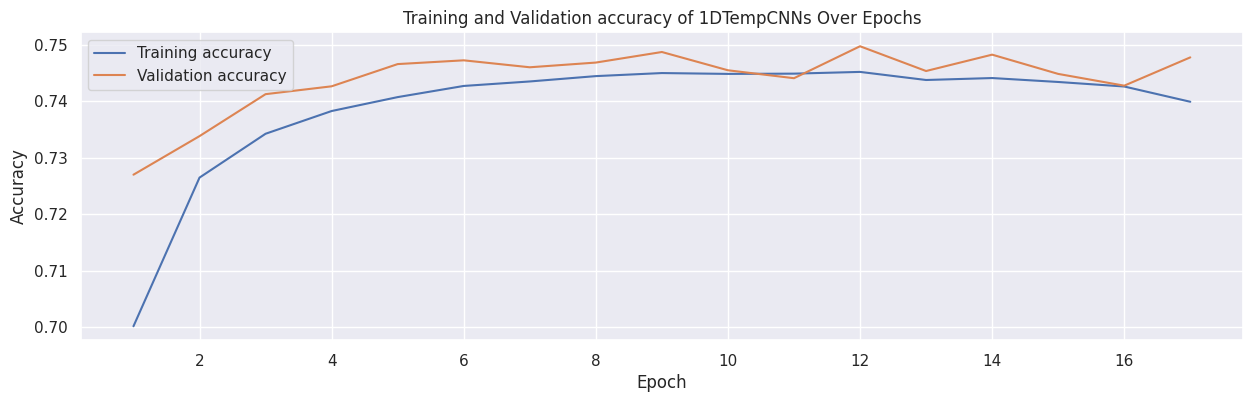

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 22, 64)              │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_layer (InceptionLayer)     │ (None, 22, 160)             │          54,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 160)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3520)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,802,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │           6,669 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,597,993 (21.35 MB)

 Trainable params: 1,865,997 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,731,996 (14.24 MB)

11189/11189 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
Recall score for test dataset:  0.7757424647424707
Precision score for test dataset:  0.770508921718091
F1 score for test dataset:  0.7700345293382054
ROC-AUC score for test dataset:  0.8772067266455961
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     39124
           1       0.81      0.74      0.77     25768
           2       0.97      0.97      0.97     40404
           3       0.49      0.63      0.55     38749
           4       0.68      0.72      0.70     26749
           5       0.66      0.61      0.63     28676
           6       0.59      0.55      0.57     33885
           7       0.74      0.87      0.80      1129
           8       0.87      0.90      0.88      8661
           9       0.97      0.96      0.96     11207
          10       0.86      0.93      0.89     38032
          11       0.87      0.91      0.89     27787
          12       0.79      0.55      0.65     

In [ ]:
# Following the goal set the inputs of the 1DSpecCNNs model:
# If only four bands are being used, use the inputs train_samples, val_samples, test_samples; other wise use the inputs Standarizad_train_samples, Standarizad_val_samples, Standarizad_test_samples
# Also, do not forget to correspondingly change the time_steps and num_features parameters
SpecCNNs(Features_training_CNN = train_samples, Features_val_CNN = val_samples, Features_testing_CNN = test_samples, landcover_training_CNN = train_labels_encoded, landcover_val_CNN = val_labels_encoded, landcover_testing_CNN = test_labels_encoded, time_steps = train_samples.shape[1], num_features = train_samples.shape[2], num_classes = 13, Prediction_only = False)



# Plotting confusion matrix of the top-performing DL model (i.e., LSTM model) on the Test dataset

358047


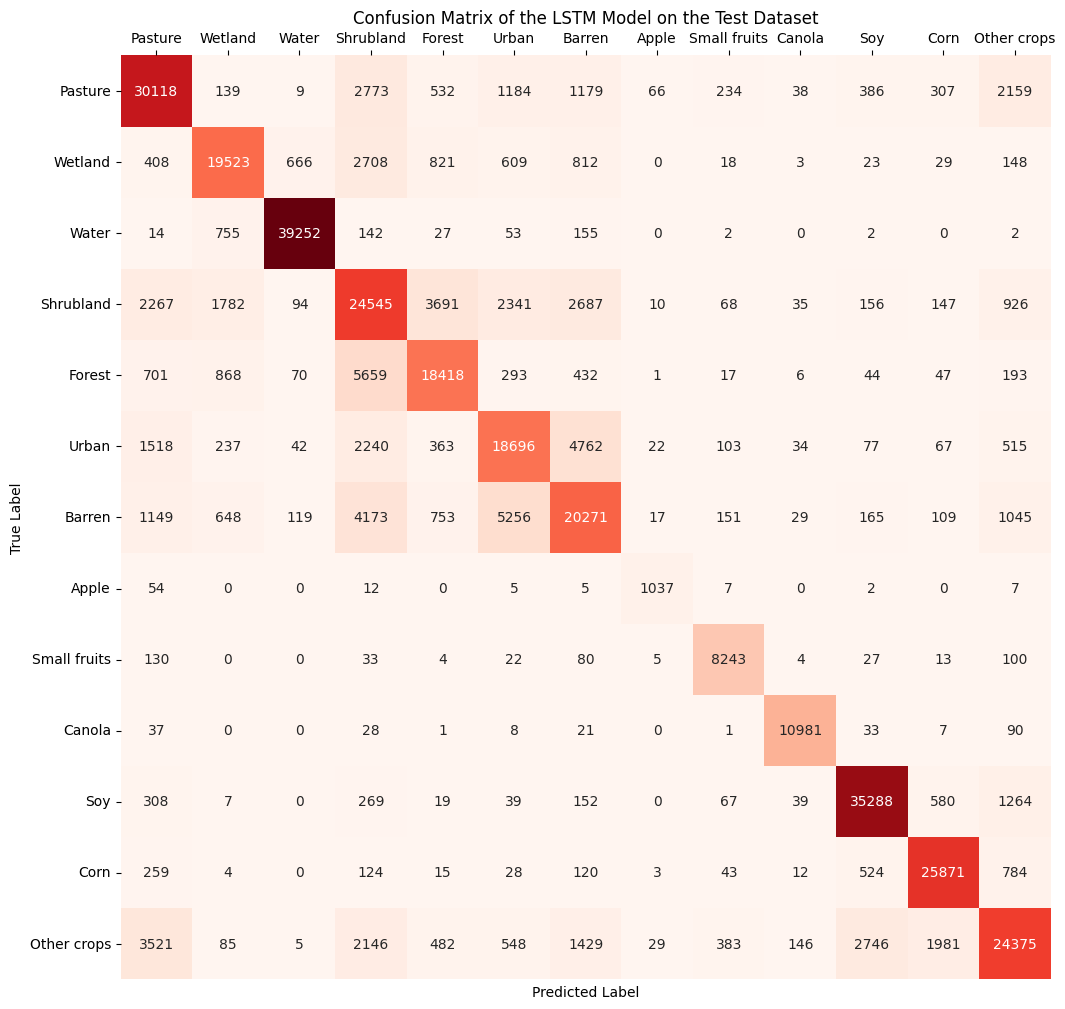

In [5]:
Conf_mat_test = np.load('/content/drive/My Drive/Confusion_matrix/confusion_matrix_LSTM_test.npy')
print(np.sum(Conf_mat_test))
class_labels = ['Pasture', 'Wetland', 'Water', 'Shrubland', 'Forest', 'Urban', 'Barren', 'Apple', 'Small fruits', 'Canola', 'Soy', 'Corn', 'Other crops']

plt.figure(figsize=(12, 12))
sns.heatmap(Conf_mat_test, annot=True, fmt='d', cmap='Reds', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of the LSTM Model on the Test Dataset')
#plt.xticks(ha='right')
plt.yticks(rotation=0, ha='right')
plt.tick_params(axis='x',  top=True, bottom=False, labeltop=True, labelbottom=False)
plt.show()

In [8]:
# Crop indices
crop_indices = [7, 8, 9, 10, 11, 12]

# Non-crop indices
non_crop_indices = [0, 1, 2, 3, 4, 5, 6]

# Essential crop indices
essential_crop_indices = [7, 8, 9, 10, 11]

# Other crop index
other_crop_index = 12

# Initialize error counters
crop_as_non_crop_errors = 0
non_crop_as_crop_errors = 0
essential_crop_as_other_crop_errors = 0
other_crop_as_essential_crop_errors = 0
inter_essential_crop_errors = 0
inter_non_crop_errors = 0

# Calculating errors
for i in range(len(class_labels)):
  for j in range(len(class_labels)):
    if i in crop_indices and j in non_crop_indices:
      crop_as_non_crop_errors += Conf_mat_test[i][j]
    elif i in non_crop_indices and j in crop_indices:
      non_crop_as_crop_errors += Conf_mat_test[i][j]
    elif i in essential_crop_indices and j == other_crop_index:
      essential_crop_as_other_crop_errors += Conf_mat_test[i][j]
    elif i == other_crop_index and j in essential_crop_indices:
      other_crop_as_essential_crop_errors += Conf_mat_test[i][j]
    elif i != j and i in essential_crop_indices and j in essential_crop_indices:
      inter_essential_crop_errors += Conf_mat_test[i][j]
    elif i != j and i in non_crop_indices and j in non_crop_indices:
      inter_non_crop_errors += Conf_mat_test[i][j]

# Print results
print("Crop as non-crop errors:", crop_as_non_crop_errors)
print("Non-crop as crop errors:", non_crop_as_crop_errors)
print("Essential crops as other crops errors:", essential_crop_as_other_crop_errors)
print("Other crops as essential crops errors:", other_crop_as_essential_crop_errors)
print("Inter-essential crops errors:", inter_essential_crop_errors)
print("Inter non-crop errors:", inter_non_crop_errors)

Crop as non-crop errors: 10000
Non-crop as crop errors: 7401
Essential crops as other crops errors: 2245
Other crops as essential crops errors: 5285
Inter-essential crops errors: 1367
Inter non-crop errors: 55131


# Saving the predicted land cover and crop type numpy in a raster file to import into ArcGIS Pro

In [8]:
# Loading the predicted land cover and crop type throughout the study area
Crop_predicted_all_study_area = np.load('/content/drive/My Drive/Crop_prediction_all_study_area/Crop_predicted_all_study_area.npy')
print('Crop_predicted_all_study_area shape: ', Crop_predicted_all_study_area.shape)

Ground_truth_crop_data_path = '/content/drive/My Drive/DL_samples/CNN_LandC_Image.tif'

with rasterio.open(Ground_truth_crop_data_path) as src:
  # Getting the metadata from the ground reference image
  profile = src.profile
  transform = src.transform
  print("src shape: ", src.shape)

  Crop_predicted_all_study_area_reshaped = Crop_predicted_all_study_area.reshape(src.shape[0],src.shape[1])

  # Creating a new raster image using the numpy array and metadata of the ground reference image
  with rasterio.open('/content/drive/My Drive/Crop_prediction_all_study_area/Crop_predicted_all_study_area.tif', 'w', **profile) as dst:
    dst.write(Crop_predicted_all_study_area_reshaped, 1)

Crop_predicted_all_study_area shape:  (36000000, 1)
src shape:  (6000, 6000)
